## Importing Required Libraries
This section imports all necessary Python libraries for data manipulation, preprocessing, modeling, and evaluation.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Loading the Dataset
Here, we load the training labels and features from CSV files.

In [2]:
X = pd.read_csv('Data\Training_set_labels.csv')
y = pd.read_csv('Data\Training_set_values.csv')


We merge the datasets on the `id` column to create a unified DataFrame.

In [3]:
df=X.merge(y,on='id')

This is a user defined function giving a brief summary on the dataset 

In [4]:
def explore_dataframe(df, name="DataFrame"): #user defined function to get the shape,info and description of the dataset
    print(f"\n===== {name} Overview =====")
    
    print("\nShape:")
    print(df.shape)
    
    print("\nInfo:")
    print("-" * 40)
    df.info()
    
    print("\nDescription:")
    print("-" * 40)
    print(df.describe(include='all'))

In [5]:
explore_dataframe(df,name='Tanzania Well Analysis')


===== Tanzania Well Analysis Overview =====

Shape:
(59400, 41)

Info:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55763 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59398 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object

## checking  missing values and filling them

In [6]:

# Calculate missing percentages
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Display missing values sorted in descending order
print(missing_percentage.sort_values(ascending=False))

scheme_name              48.501684
scheme_management         6.528620
installer                 6.153199
funder                    6.122896
public_meeting            5.612795
permit                    5.144781
subvillage                0.624579
wpt_name                  0.003367
source                    0.000000
management_group          0.000000
waterpoint_type           0.000000
source_class              0.000000
extraction_type_group     0.000000
source_type               0.000000
extraction_type_class     0.000000
management                0.000000
payment                   0.000000
quantity_group            0.000000
payment_type              0.000000
water_quality             0.000000
extraction_type           0.000000
quality_group             0.000000
quantity                  0.000000
id                        0.000000
recorded_by               0.000000
construction_year         0.000000
status_group              0.000000
population                0.000000
ward                

In [7]:
# For categorical columns - fill with mode
cols_to_impute = ['scheme_management', 'installer', 'funder', 'public_meeting', 'permit', 'subvillage', 'wpt_name']

for col in cols_to_impute:
    df[col] = df[col].fillna(df[col].mode()[0])

# Optional: drop 'scheme_name' due to high missing %
df = df.drop(columns=['scheme_name'])


In [8]:

df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
59395    False
59396    False
59397    False
59398    False
59399    False
Length: 59400, dtype: bool

## Visualisations

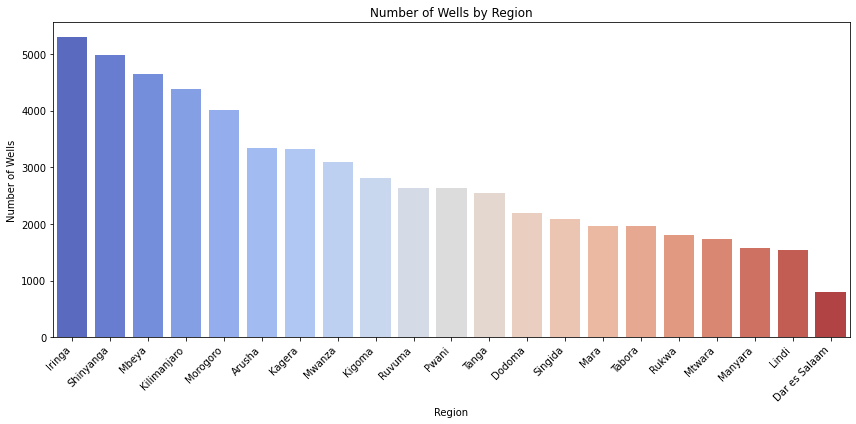

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Step 2: Count wells per region
region_counts = df['region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Well Count']

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=region_counts, x='Region', y='Well Count', palette='coolwarm')
plt.title('Number of Wells by Region')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Region')
plt.ylabel('Number of Wells')
plt.tight_layout()
plt.show()

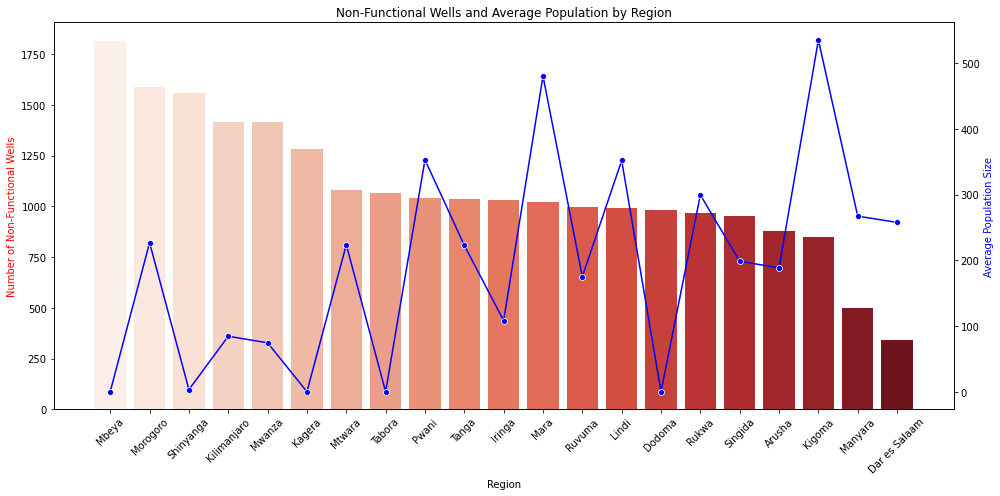

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is the main DataFrame and already loaded with 'region', 'status_group', and 'population'

# Filter for non-functional wells
non_functional_df = df[df['status_group'] == 'non functional']

# Group by region and aggregate count of non-functional wells and average population
region_summary = non_functional_df.groupby('region').agg({
    'id': 'count',
    'population': 'mean'
}).rename(columns={'id': 'non_functional_wells', 'population': 'avg_population'}).reset_index()

# Sort by number of non-functional wells for better visualization
region_summary = region_summary.sort_values(by='non_functional_wells', ascending=False)

# Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for non-functional wells
sns.barplot(
    data=region_summary,
    x='region',
    y='non_functional_wells',
    palette='Reds',
    ax=ax1
)
ax1.set_ylabel('Number of Non-Functional Wells', color='red')
ax1.set_xlabel('Region')
ax1.tick_params(axis='x', rotation=45)

# Create second y-axis for average population
ax2 = ax1.twinx()
sns.lineplot(
    data=region_summary,
    x='region',
    y='avg_population',
    color='blue',
    marker='o',
    ax=ax2
)
ax2.set_ylabel('Average Population Size', color='blue')

plt.title('Non-Functional Wells and Average Population by Region')
plt.tight_layout()
plt.show()




## Encoding the Categorical Variables 

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

features = ['funder', 'installer', 'gps_height', 'longitude', 'latitude', 'population', 'public_meeting']
X = df[features]
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_cols = ['funder', 'installer', 'public_meeting']  # categorical columns
num_cols = ['gps_height', 'longitude', 'latitude', 'population']  # numeric columns

# Setup ColumnTransformer to apply OneHotEncoder to categorical columns only
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  # numeric columns passed without change
)

# Fit and transform train data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Now train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [10]:
# Generate predictions (class labels) on the test set
y_pred = model.predict(X_test)

# Generate prediction probabilities for positive class (useful for ROC AUC)
y_prob = model.predict_proba(X_test)


In [11]:
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Precision:", precision_score(y_test, y_pred, average='weighted'))

print("Recall:", recall_score(y_test, y_pred, average='weighted'))

print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("ROC AUC:", roc_auc_score(y_test, y_prob, multi_class='ovr'))  # ovn or ovr for multiclass ROC AUC


Accuracy: 0.5887205387205388
Precision: 0.5704126121687745
Recall: 0.5887205387205388
F1 Score: 0.554683434486135
ROC AUC: 0.6668675266843823


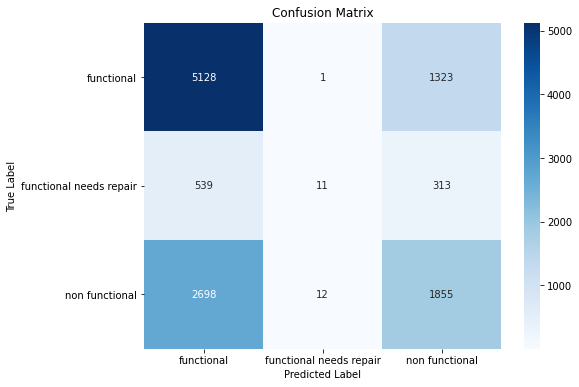

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Class 0 is mostly predicted correctly (5128), but misclassified as Class 2 (1323 times).

Class 1 is poorly predicted — only 11 correct predictions out of 863 (11+539+313), which is ~1.3% accuracy for Class 1.

Class 2 is also often misclassified as Class 0 (2698 times), despite 1855 correct predictions

In [13]:
# Check class distribution in y_test
print("Class distribution in test set:")
print(y_test.value_counts())

# Check class distribution in full dataset (replace y with your full target)
print("\nClass distribution in entire dataset:")
print(y.value_counts())


Class distribution in test set:
status_group
functional                 6452
non functional             4565
functional needs repair     863
Name: count, dtype: int64

Class distribution in entire dataset:
status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64


The class "functional needs repair" is severely underrepresented (just 7% of data).

This explains the confusion matrix issue:

Your model performs very poorly on this class.

Even Class 1 (functional needs repair) samples are being predicted as either Class 0 or 2.

Likely the model is biased toward the dominant classes (Functional and Non-functional).

## Model 2

In [14]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample

# === 1. Convert sparse X_train to DataFrame if needed ===
# Converts a sparse matrix (from OneHotEncoder or similar) to a DataFrame so we can manipulate it
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train)

# Convert y_train (likely a NumPy array or Series) into a pandas Series and reset index
y_train_series = pd.Series(y_train).reset_index(drop=True)

# === 2. Convert y_train to binary target ===
# Functional = 1 (positive class), everything else = 0 (negative class: needs repair or non functional)
y_train_binary = y_train_series.apply(lambda x: 1 if x == 'functional' else 0)

# === 3. Combine for resampling ===
# Copy X_train_df and add the binary labels as a new column called 'target' to form a combined DataFrame
train_df = X_train_df.copy()
train_df['target'] = y_train_binary

# === 4. Resample to balance binary classes ===
# Separate rows based on binary class
df_positive = train_df[train_df['target'] == 1]  # Functional
df_negative = train_df[train_df['target'] == 0]  # Non-functional or needs repair

# Downsample the majority class (functional) to 5000 samples
df_positive_down = resample(df_positive, replace=False, n_samples=5000, random_state=42)

# Upsample the minority class (not functional) to 5000 samples
df_negative_up = resample(df_negative, replace=True, n_samples=5000, random_state=42)

# Combine the downsampled and upsampled data, then shuffle to mix rows
df_balanced = pd.concat([df_positive_down, df_negative_up])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# === 5. Split balanced dataset back into features and target ===
# Drop the target column to get the resampled features
X_train_bal = df_balanced.drop('target', axis=1)

# Save the target column as the new resampled y_train
y_train_bal = df_balanced['target']

# === 6. Train Decision Tree ===
# Fit a Decision Tree with max depth 10 and balanced class weights to account for class imbalance
clf = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)
clf.fit(X_train_bal, y_train_bal)

# === 7. Prepare y_test as binary ===
# Apply same transformation to y_test: functional → 1, else → 0
y_test_binary = pd.Series(y_test).apply(lambda x: 1 if x == 'functional' else 0)

# === 8. Predict and evaluate ===
# Predict binary class on the original test set
y_pred = clf.predict(X_test)

# Print precision, recall, f1-score, and support for each class
print(classification_report(y_test_binary, y_pred))


              precision    recall  f1-score   support

           0       0.60      0.65      0.62      5428
           1       0.68      0.63      0.66      6452

    accuracy                           0.64     11880
   macro avg       0.64      0.64      0.64     11880
weighted avg       0.64      0.64      0.64     11880



Precision
Class 0 (0.60): Out of all predictions the model made as "not functional", 60% were correct.

Class 1 (0.68): Out of all predictions made as "functional", 68% were correct.

Precision is important when false positives are costly.
Example: You wrongly say a pump is functional (but it isn’t) → may delay repair.

Recall
Class 0 (0.65): The model correctly found 65% of the actual non-functional pumps.

Class 1 (0.63): The model found 63% of the actual functional pumps.

Recall is important when false negatives are costly.
Example: You fail to detect a broken pump → leads to service disruption.

F1-score
Harmonic mean of precision and recall.

Balances the trade-off between them.

Class 0 (0.62), Class 1 (0.66) — good but room to improve.



In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 1. Set up parameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# 2. Initialize model
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# 3. Set up GridSearchCV
grid_search = GridSearchCV(estimator=dt,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# 4. Fit on the balanced training set
grid_search.fit(X_train_bal, y_train_bal)

# 5. Best model
best_dt = grid_search.best_estimator_

# 6. Predict on test set
y_pred = best_dt.predict(X_test)

# 7. Evaluate
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.63      5428
           1       0.69      0.71      0.70      6452

    accuracy                           0.67     11880
   macro avg       0.66      0.66      0.66     11880
weighted avg       0.67      0.67      0.67     11880



You achieved moderate accuracy (67%), a good sign after class balancing and tuning.

Class 1 (functional) is predicted slightly better than class 0 — higher recall and F1.

Class 0 (not functional) may benefit from:

More training data.

Cost-sensitive training or higher penalty for false negatives.

Trying models like Random Forest, XGBoost, or LightGBM.



 ## Model 3 Random Forest 

In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# --- Assume X_train, X_test, y_train, y_test are already defined ---

# Step 1: Define mapping for binary classification
target_mapping = {
    'functional': 0,
    'functional needs repair': 0,
    'non functional': 1
}

# Step 2: Map y_train and y_test to binary labels
y_train_binary = y_train.map(target_mapping)
y_test_binary = y_test.map(target_mapping)

# Step 3: Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Step 4: Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Step 5: Setup GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1)

# Step 6: Fit on training data
grid_search.fit(X_train, y_train_binary)

# Step 7: Best estimator
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Step 8: Predict on test data
y_pred_rf = best_rf.predict(X_test)

# Step 9: Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_rf))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      7315
           1       0.75      0.66      0.70      4565

    accuracy                           0.78     11880
   macro avg       0.78      0.76      0.77     11880
weighted avg       0.78      0.78      0.78     11880

Confusion Matrix:
[[6311 1004]
 [1553 3012]]


Class 0 — Functional
Very strong recall (0.86): most functional pumps are correctly detected.

High precision (0.80): few false positives.

F1 = 0.83 → overall, your model handles Class 0 well.

Class 1 — Non-Functional
Recall (0.66) is lower: about 34% of non-functional pumps are missed.

Precision (0.75) is decent, so most predicted non-functionals are indeed correct.

F1 = 0.70 → reasonable performance, but room to improve recall.